Author: *Davide Cittaro*   
First compiled: *February 9, 2018.*

## Cell-Cycle Scoring and Regression

This is a _Scanpy_ demo that shows how to regress cell cycle effect, following the approach showed in [Seurat's vignette](http://satijalab.org/seurat/cell_cycle_vignette.html#assign-cell-cycle-scores). As for the R example, toy dataset consists of murine hematopoietic progenitors from [Nestorowa et al., Blood 2016](https://doi.org/10.1182/blood-2016-05-716480). The files of the Seurat tutorial - used here for reasons of benchmarking - can be downloaded [here](https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1). A more recent version of the dataset can be downloaded [here](http://blood.stemcells.cam.ac.uk/data/nestorowa_corrected_log2_transformed_counts.txt.gz).

In [1]:
import h5py
import numpy as np
import pandas as pd
%matplotlib inline

/cluster/work/bewi/members/tuncel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import scanpy.api as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 1.0.3 on 2018-04-26 16:55.
Dependencies: anndata==0.5.8 numpy==1.14.0 scipy==0.19.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 


Load data

In [3]:
input_file = '/cluster/home/mtuncel/sc-pipe/intermediate_files/coding_region_only_melanomaS2.h5'
h5f = h5py.File(input_file, 'r')

In [4]:
matrix = h5f['matrix'][:]
barcodes = h5f['cell_attrs']['cell_names'].value
gene_ids = h5f['gene_attrs']['gene_ids'].value
gene_names = h5f['gene_attrs']['gene_names'].value
decoder = np.vectorize(lambda t: t.decode('UTF-8'))
barcodes = decoder(barcodes)
gene_ids = decoder(gene_ids)
gene_names = decoder(gene_names)

In [5]:
matrix.shape

(2216, 15324)

In [6]:
type(gene_names)

numpy.ndarray

In [7]:
adata = sc.AnnData(X=matrix, var=gene_names)

In [8]:
adata.X.shape

(2216, 15324)

### Normalize per cell

In [9]:
sc.pp.normalize_per_cell(adata)

In [10]:
cnt_mat = adata.X.copy()

### Log (counts + 1)

In [11]:
sc.pp.log1p(adata)

In [12]:
log_cnt_mat = adata.X.copy()

Load cell cycle genes defined in [Tirosh et al, 2015](https://doi.org/10.1126/science.aad0501). It is a list of 97 genes, represented by their gene symbol. The list here is for humans, in case of alternate organism, a list of ortologues should be compiled.
There are major differences in the way _Scanpy_ and _Seurat_ manage data, in particular we need to filter out cell cycle genes that are not present in our dataset to avoid errors.

In [13]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

Here we define two lists, genes associated to the S phase and genes associated to the G2M phase

In [14]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var[0].values]

In [15]:
# this is needed otherwise scanpy cannot tell the index
adata.var_names = gene_names

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We here perform cell cycle scoring. The function is actually a wrapper to `sc.tl.score_gene_list`, which is launched twice, to score separately S and G2M phases. Both `sc.tl.score_gene_list` and `sc.tl.score_cell_cycle_genes` are a port from _Seurat_ and are supposed to work in a very similar way. 
To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list.
Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [16]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:25.52) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:24.04) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


In [17]:
np.array(adata.obs['phase'].values)

array(['G1', 'G2M', 'G1', ..., 'G1', 'G1', 'G1'], dtype=object)

Here comes another difference from _Seurat_. The R package stores raw data, scaled data and variable genes information in separate slots, _Scanpy_ instead keeps only one snapshot of the data. This implies that PCA is always calculated on the entire dataset. In order to calculate PCA reduction using only a subset of genes (like `cell_cycle_genes`), a trick should be used.
Basically we create a dummy object to store information of PCA projection, which is then reincorporated into original dataset.

... storing 'phase' as categorical


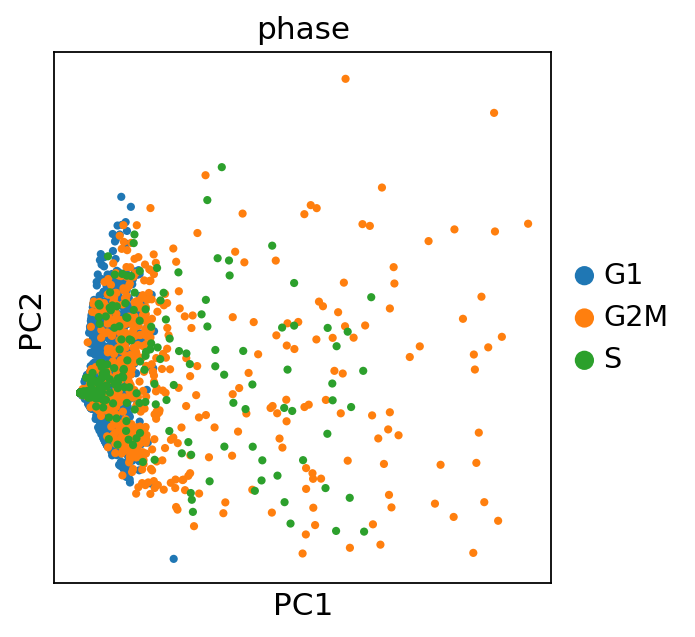

In [18]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

As in the original vignette, cells can be easily separated by their cell cycle status when cell cycle genes are used.
Now we can regress out both S score and G2M score.

### Regressing out

In [18]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

regressing out ['S_score', 'G2M_score']


/cluster/work/bewi/members/tuncel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


    finished (0:00:54.44)


In [19]:
corrected_log_cnt_mat = adata.X.copy()

In [20]:
corrected_log_cnt_mat.max()

6.172945

### Compute the scaling factors

In [21]:
scaling_factors = np.exp(corrected_log_cnt_mat - log_cnt_mat)

In [22]:
scaling_factors.min()

0.0102010155

In [47]:
flattened_sf = scaling_factors.ravel()
df_fsf = pd.DataFrame(flattened_sf)
df_fsf.plot(kind='hist')

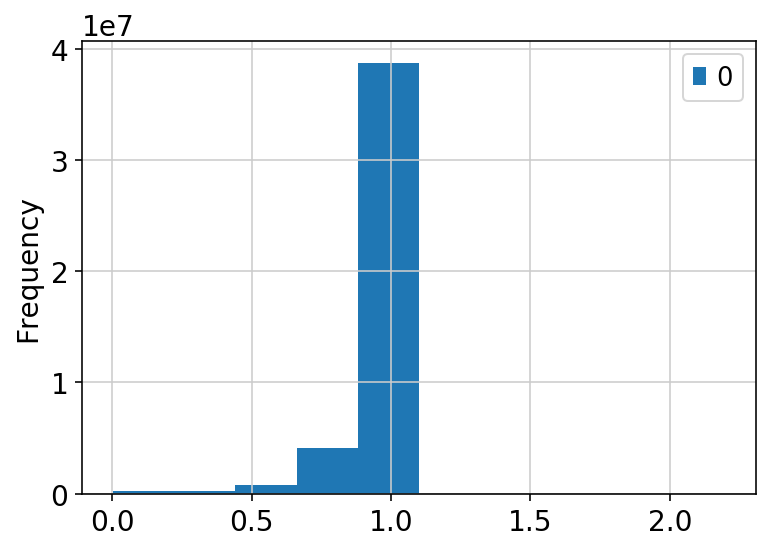

### multiply original counts by the scaling factors

In [23]:
corrected_cnt_mat = scaling_factors * cnt_mat

In [78]:
sanity2 = np.log(scaling_factors * (cnt_mat+1))

In [79]:
sanity2.max()

6.2262936

In [96]:
pd.DataFrame(sanity2).head()

,0,1,2,3,4,5,6,7,8,9,...,19918,19919,19920,19921,19922,19923,19924,19925,19926,19927
0,-0.000270,-0.000961,-0.036762,-0.001294,-0.000151,-0.002382,-0.001868,-0.001565,-0.000303,-0.005745,...,-0.000402,-0.013724,-0.000919,-0.009026,0.754957,-0.001703,-0.001452,-0.005833,-0.025945,-0.000099
1,-0.000322,-0.000829,-0.038681,-0.001324,-0.000082,-0.001921,-0.001952,-0.002399,-0.000343,-0.007476,...,-0.000576,-0.013045,-0.001233,-0.007073,-0.066129,-0.001659,-0.001484,-0.007029,-0.027612,0.000026
2,-0.000229,-0.001039,-0.034567,-0.001201,-0.000179,-0.002674,-0.001748,-0.001283,-0.000260,-0.005411,...,-0.000273,-0.013571,-0.000749,-0.010157,-0.068544,-0.002178,-0.001330,-0.005306,-0.025952,-0.000168
3,0.000226,-0.001685,-0.005490,0.000338,-0.000286,-0.005289,-0.000035,-0.001077,0.000297,-0.009610,...,0.001068,-0.006668,0.000528,-0.019361,-0.074120,-0.010686,0.000737,-0.002735,-0.036072,-0.000689
4,-0.000256,-0.001010,-0.036592,-0.001321,-0.000183,-0.002544,-0.001873,-0.001149,-0.000298,-0.004755,...,-0.000352,-0.014256,-0.000796,-0.009760,-0.068378,-0.001491,-0.001493,-0.005300,-0.024825,-0.000148


In [97]:
pd.DataFrame(corrected_log_cnt_mat).head()

,0,1,2,3,4,5,6,7,8,9,...,19918,19919,19920,19921,19922,19923,19924,19925,19926,19927
0,-0.000270,-0.000961,-0.036762,-0.001294,-0.000151,-0.002382,-0.001868,-0.001565,-0.000303,-0.005745,...,-0.000402,-0.013724,-0.000919,-0.009026,0.754957,-0.001703,-0.001452,-0.005833,-0.025945,-0.000099
1,-0.000322,-0.000829,-0.038681,-0.001324,-0.000082,-0.001921,-0.001952,-0.002399,-0.000343,-0.007476,...,-0.000576,-0.013045,-0.001233,-0.007073,-0.066129,-0.001659,-0.001484,-0.007029,-0.027612,0.000026
2,-0.000229,-0.001039,-0.034567,-0.001201,-0.000179,-0.002674,-0.001748,-0.001283,-0.000260,-0.005411,...,-0.000273,-0.013571,-0.000749,-0.010157,-0.068544,-0.002178,-0.001330,-0.005306,-0.025952,-0.000168
3,0.000226,-0.001685,-0.005490,0.000338,-0.000286,-0.005289,-0.000035,-0.001077,0.000297,-0.009610,...,0.001068,-0.006668,0.000528,-0.019361,-0.074120,-0.010686,0.000737,-0.002735,-0.036072,-0.000689
4,-0.000256,-0.001010,-0.036592,-0.001321,-0.000183,-0.002544,-0.001873,-0.001149,-0.000298,-0.004755,...,-0.000352,-0.014256,-0.000796,-0.009760,-0.068378,-0.001491,-0.001493,-0.005300,-0.024825,-0.000148


In [80]:
corrected_log_cnt_mat.max()

6.2262936

### Sanity check

In [107]:
np.allclose(sanity2, corrected_log_cnt_mat, atol=1e-05)

True

In [100]:
sanity2[1]

array([-3.2239387e-04, -8.2890759e-04, -3.8681276e-02, ...,
       -7.0285457e-03, -2.7612105e-02,  2.5868081e-05], dtype=float32)

In [101]:
corrected_log_cnt_mat[1]

array([-3.2241069e-04, -8.2893670e-04, -3.8681258e-02, ...,
       -7.0285727e-03, -2.7612105e-02,  2.5823088e-05], dtype=float32)

In [99]:
sanity2 == corrected_log_cnt_mat

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [94]:
np.allclose(corrected_log_cnt_mat, sanity2)

False

In [24]:
(sanity2==corrected_log_cnt_mat).all()

NameError: name 'sanity2' is not defined

In [25]:
corrected_cnt_mat.shape

(2216, 15324)

In [26]:
corrected_cnt_mat.max()

479.45532

In [29]:
pd.DataFrame(corrected_cnt_mat).describe()

,0,1,2,3,4,5,6,7,8,9,...,15314,15315,15316,15317,15318,15319,15320,15321,15322,15323
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,0.007418,0.169087,0.006057,0.026394,0.188527,1.689141,0.054634,0.011718,0.000721,0.177020,...,1.954422,0.058592,1.903268,1.980918,1.642125,0.433436,1.710588,1.474768,0.316201,1.986227
std,0.087860,0.392479,0.075113,0.180097,0.613785,4.665863,0.244748,0.106079,0.026392,0.889784,...,2.921762,0.243145,2.774063,3.006862,2.539208,0.796434,2.267967,1.895174,0.749456,2.993312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.485667,0.000000,0.486788,0.450514,0.410463,0.000000,0.510283,0.459368,0.000000,0.465250
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.361094,0.000000,0.000000,0.000000,0.000000,...,0.744646,0.000000,0.770659,0.741693,0.720656,0.000000,0.786762,0.766813,0.000000,0.727559
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.310885,0.000000,0.000000,0.000000,0.000000,...,1.532975,0.000000,1.580295,1.581062,1.362464,0.650278,1.470443,1.415754,0.275615,1.590971
max,1.497921,3.471128,1.584115,2.807682,10.303338,70.429626,2.973293,1.698543,1.164438,17.987097,...,14.982944,2.573803,15.712990,16.921932,33.169441,6.832867,17.912071,12.379186,7.179687,16.695765


Finally, we reproject dataset using cell cycle genes again. Since we regressed the scores, no effect of cell cycle is now evident.

... storing 'phase' as categorical


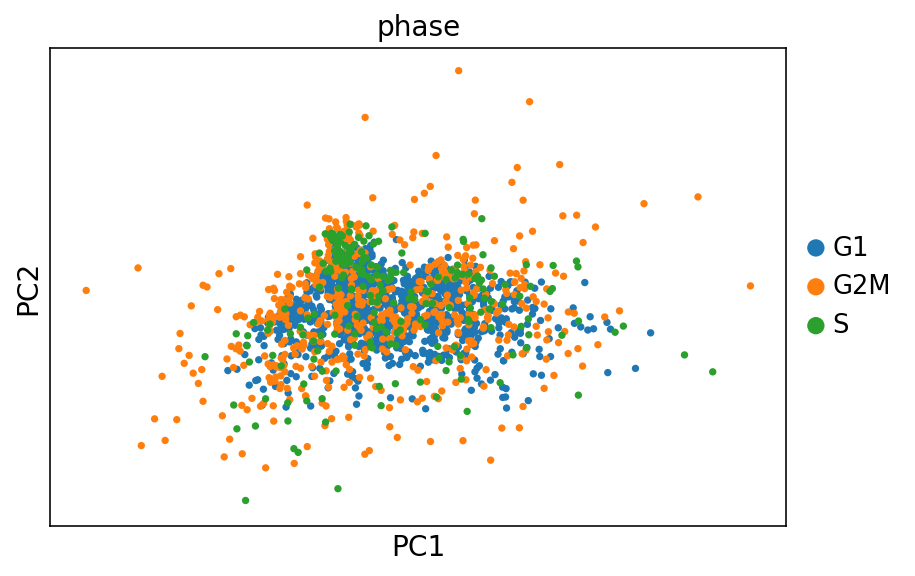

In [108]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [134]:
corrected_cnt_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [135]:
corrected_cnt_mat.max()

505.7368

In [111]:
import time
import phenograph
from sklearn.manifold import TSNE
%matplotlib inline

In [112]:
current = time.time()
communities, graph, Q = phenograph.cluster(corrected_cnt_mat, n_jobs=12, k=100, primary_metric='euclidean')
end = time.time()
diff = end - current

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 24.540417432785034 seconds
Jaccard graph constructed in 5.822391033172607 seconds
Wrote graph to binary file in 1.4779822826385498 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.759811
Louvain completed 21 runs in 7.17283296585083 seconds
PhenoGraph complete in 39.20839977264404 seconds


In [113]:
from collections import Counter

In [114]:
Counter(communities)

Counter({0: 495, 1: 471, 2: 355, 3: 300, 4: 292, 5: 157, 6: 146})

In [118]:
arr = graph.toarray()
arr_full = arr+arr.T
np.fill_diagonal(arr_full, 1)
dist = (arr_full- arr_full.max())*(-1)
np.fill_diagonal(dist, 0)
tsne = TSNE(n_components=2, perplexity= 100,metric='precomputed').fit_transform(dist)

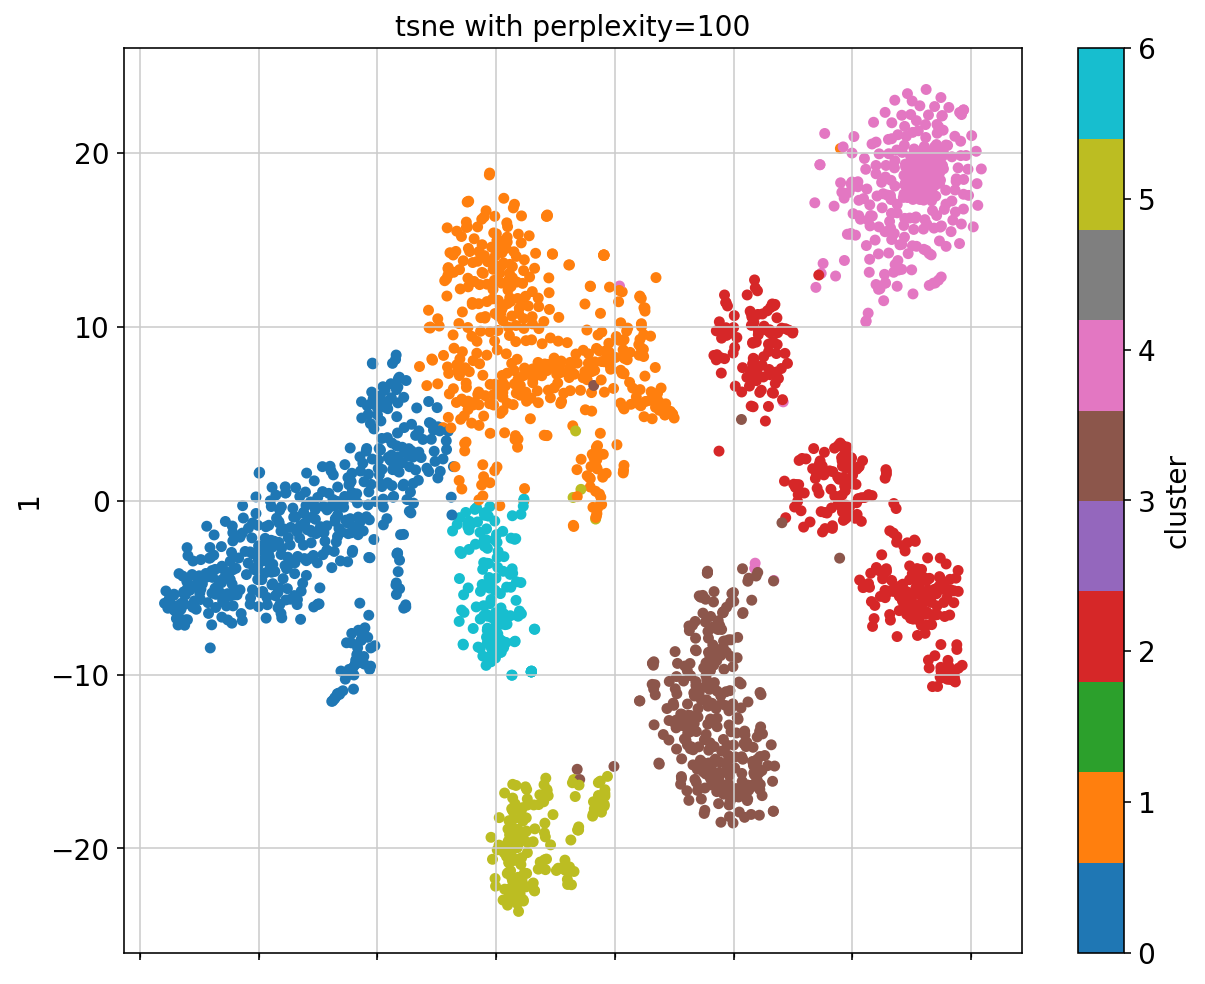

In [120]:
df_tsne = pd.DataFrame(tsne)
df_tsne['cluster'] = communities
#df_tsne['ground_truth'] = cell_groups
#df_tsne['ground_truth'] = df_tsne['ground_truth'].apply(lambda x: int(str(x, 'utf-8')[-1]))
df_tsne.plot(kind='scatter', x=0, y=1, c='cluster', figsize=(10,8),colormap='tab10', grid=True, title='tsne with perplexity=100')

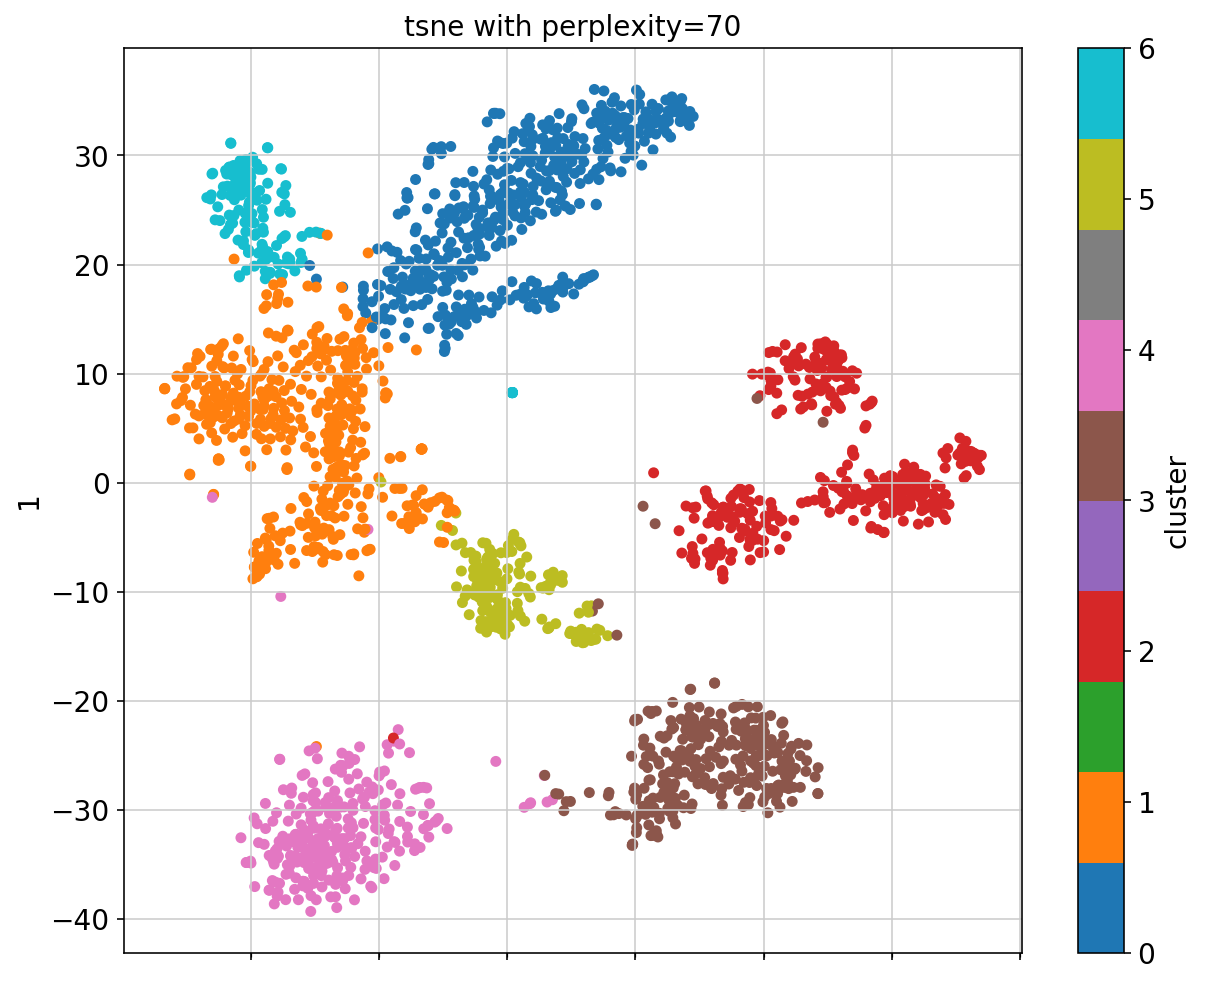

In [117]:
df_tsne = pd.DataFrame(tsne)
df_tsne['cluster'] = communities
#df_tsne['ground_truth'] = cell_groups
#df_tsne['ground_truth'] = df_tsne['ground_truth'].apply(lambda x: int(str(x, 'utf-8')[-1]))
df_tsne.plot(kind='scatter', x=0, y=1, c='cluster', figsize=(10,8),colormap='tab10', grid=True, title='tsne with perplexity=70')

## Alternative workflow
### Selecting 1000 genes by dispersion

In [121]:
filter_result = sc.pp.filter_genes_dispersion(corrected_cnt_mat, flavor='cell_ranger', n_top_genes=1000, log=False)

In [126]:
variable_genes = corrected_cnt_mat[:,filter_result.gene_subset]

In [127]:
variable_genes.shape

(2216, 999)

In [129]:
current = time.time()
var_genes_communities, var_genes_graph, var_genes_Q = phenograph.cluster(variable_genes, n_jobs=12, k=100, primary_metric='euclidean')
end = time.time()
diff = end - current

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8702824115753174 seconds
Jaccard graph constructed in 4.388762950897217 seconds
Wrote graph to binary file in 0.6530208587646484 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788778
Louvain completed 21 runs in 6.7286176681518555 seconds
PhenoGraph complete in 13.798608303070068 seconds


In [130]:
Counter(var_genes_communities)

Counter({0: 423,
         1: 296,
         2: 273,
         3: 262,
         4: 254,
         5: 250,
         6: 203,
         7: 157,
         8: 98})

In [131]:
arr = var_genes_graph.toarray()
arr_full = arr+arr.T
np.fill_diagonal(arr_full, 1)
dist = (arr_full- arr_full.max())*(-1)
np.fill_diagonal(dist, 0)
tsne = TSNE(n_components=2, perplexity= 70,metric='precomputed').fit_transform(dist)

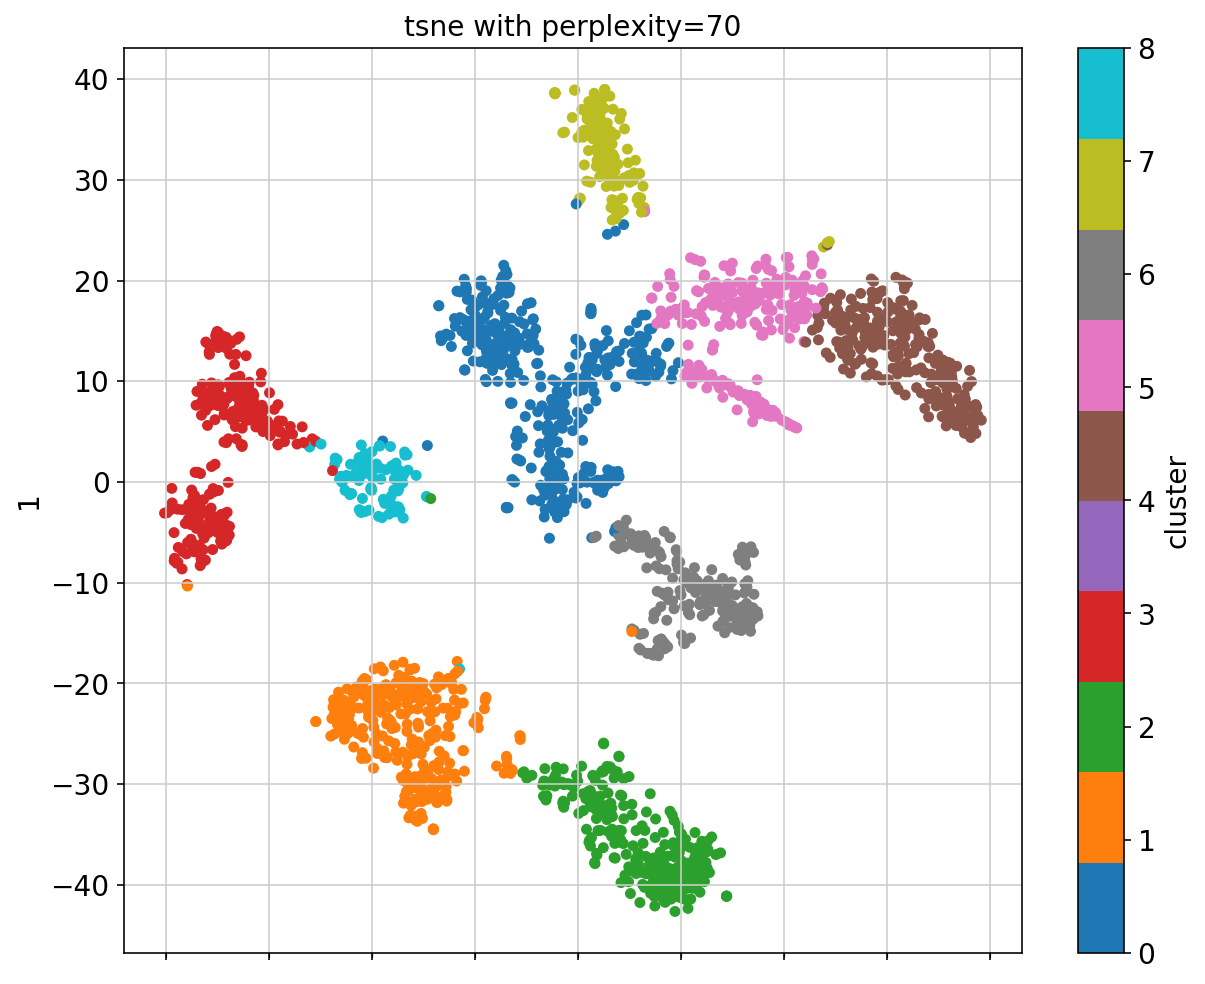

In [132]:
df_tsne = pd.DataFrame(tsne)
df_tsne['cluster'] = communities
#df_tsne['ground_truth'] = cell_groups
#df_tsne['ground_truth'] = df_tsne['ground_truth'].apply(lambda x: int(str(x, 'utf-8')[-1]))
df_tsne.plot(kind='scatter', x=0, y=1, c='cluster', figsize=(10,8),colormap='tab10', grid=True, title='tsne with perplexity=70')